# 1. Introduction
The dataset used in this project includes data for the estimation of obesity levels in individuals from the countries of Mexico, Peru and Colombia, based on their eating habits and physical condition. The original data contains 17 attributes and 2111 records, the records are labeled with the class variable "Obesity Level", that allows classification of the data using the values of Insufficient Weight, Normal Weight, Overweight Level I, Overweight Level II, Obesity Type I, Obesity Type II and Obesity Type III.

The data and complete information about the variables is available in: https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition

The objective of this notebook is to show how to develop a model to predict overweight and level of weight based on the following attributes: 

    'Gender': 1 for Male, 0 for Female
    'Age': Age in years
    'Height': Height in meters
    'Weight': Weight in kilograms
    'family_history_with_overweight': 1 for yes, 0 for no
    'FAVC': Eat high caloric food: 1 for yes, 0 for no
    'FCVC': Frequency for vegetables consumption: Never = 1, Sometimes = 2, Always = 3    
    'NCP': Daily number of meals: Between 1-2 = 1, Three = 2, More than three = 3
    'CAEC': Frequency for eating between meals: No = 0, Sometimes = 1, Frequently = 2, Always = 3
    'SMOKE': 1 for yes, 0 for no
    'CH2O': Water consumption: < 1 Liter = 1, 1-2 Liters = 2, > 2 Liters = 3
    'SCC': Monitor calories: 1 for yes, 0 for no
    'FAF': Frequency for physical activity: Do not do any = 0, 1-2 times/week = 1, 3-4 times/week = 2, > 4 times/week = 3
    'TUE': Time spent on technological devices: < 2 hours = 0, 2-5 hours = 1, > 5 hours = 2
    'CALC': Frequency for alcohol consumption: Do not drink = 0, Sometimes = 1, Frequently = 2, Always = 3
    'MTRANS': Transportation mode: Public_Transportation = 1, Walking = 2, Automobile = 3, Motorbike = 4, Bike = 5

The first model predicts if a person is or not overweight and the second model , which includes every level after Normal Weight, and the second model predicts the specific level.

# 2. Import required libraries
Import necessary libraries such as pandas, matplotlib, seaborn, and scipy for running the code.

In [1]:
import pandas as pd
import plotnine as pn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, RocCurveDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, KFold, GridSearchCV, validation_curve
from mlxtend.plotting import plot_decision_regions
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier

from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
    VotingClassifier
)

%matplotlib inline

# 3. Data pre-processing
Load, visualize and pre-process the dataset.

In [28]:
# https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition

# Load the dataset
data = 'Data/RawData.csv'

# Read the dataset
data = pd.read_csv(data)
data.head()


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [29]:
# Identify missing values
data.isnull().sum()
print(data.isnull().sum())

# Shape of the dataset
data.shape
print(data.shape)

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64
(2111, 17)


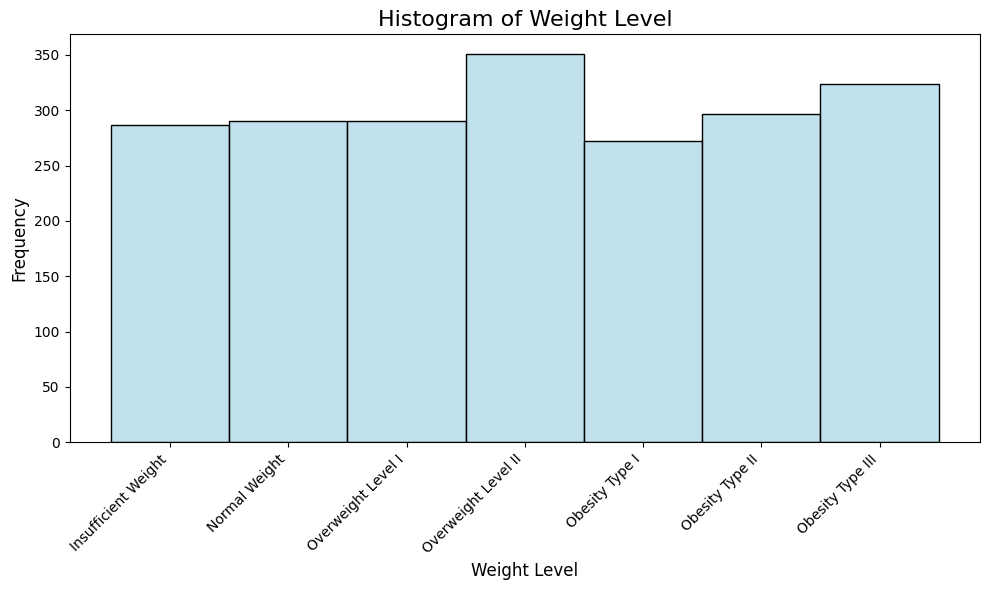

In [33]:
# Distribution of Weight Level
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='NObeyesdad', bins=7, kde=False, color='lightblue')
plt.title('Histogram of Weight Level', fontsize=16)
plt.xlabel('Weight Level', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(ticks=range(0, 7), labels=[
    'Insufficient Weight', 
    'Normal Weight', 
    'Overweight Level I', 
    'Overweight Level II', 
    'Obesity Type I', 
    'Obesity Type II', 
    'Obesity Type III'
], rotation=45, ha='right')
plt.tight_layout()
plt.show()

/tmp/ipykernel_6594/558028300.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



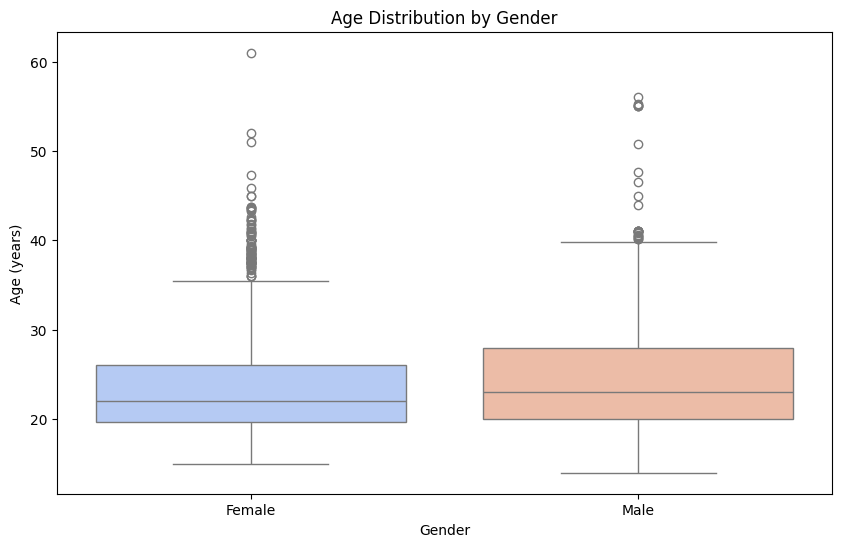

In [35]:
# Box plot to explore the distribution of 'Age' by 'Gender'
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='Gender', y='Age', palette='coolwarm')
plt.title('Age Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Age (years)')
plt.show()

In [37]:
# Transform all the categorical x variables into numerical variables

# Transform 'Gender' column to numerical values, Female 0 and Male 1
data['Gender'] = data['Gender'].map({'Female': 0, 'Male': 1})

# Transform binary columns to numerical values (yes = 1, no = 0)
columns_to_transform = ['family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']
for column in columns_to_transform:
    data[column] = data[column].map({'yes': 1, 'no': 0})

# Transform 'CAEC' column to numerical values
data['CAEC'] = data['CAEC'].map({'Always': 3, 'Frequently': 2, 'Sometimes': 1, 'no': 0})
# Transform 'CALC' column to numerical values
data['CALC'] = data['CALC'].map({'Always': 3, 'Frequently': 2, 'Sometimes': 1, 'no': 0})
# Transform 'MTRANS' column to numerical values
data['MTRANS'] = data['MTRANS'].map({'Public_Transportation': 1, 'Walking' : 2, 'Automobile': 3, 'Motorbike': 4, 'Bike': 5})

In [38]:
# Transform 'NObeyesdad' column to numerical values Overweight = 1, No_Overweight = 0
data['Overweight'] = data['NObeyesdad'].map({
    'Insufficient_Weight': 0,
    'Normal_Weight': 0,
    'Overweight_Level_I': 1,
    'Overweight_Level_II': 1,
    'Obesity_Type_I': 1,
    'Obesity_Type_II': 1,
    'Obesity_Type_III': 1
})

# 1) Transform 'NObeyesdad' column to numerical values and create a new column 'WeightLevel'
data['WeightLevel'] = data['NObeyesdad'].map({
    'Insufficient_Weight': 1,
    'Normal_Weight': 2,
    'Overweight_Level_I': 3,
    'Overweight_Level_II': 4,
    'Obesity_Type_I': 5,
    'Obesity_Type_II': 6,
    'Obesity_Type_III': 7
})


In [39]:
# Statistical description of the DataFrame
data.describe()
print(data.describe())

            Gender          Age       Height       Weight  \
count  2111.000000  2111.000000  2111.000000  2111.000000   
mean      0.505921    24.312600     1.701677    86.586058   
std       0.500083     6.345968     0.093305    26.191172   
min       0.000000    14.000000     1.450000    39.000000   
25%       0.000000    19.947192     1.630000    65.473343   
50%       1.000000    22.777890     1.700499    83.000000   
75%       1.000000    26.000000     1.768464   107.430682   
max       1.000000    61.000000     1.980000   173.000000   

       family_history_with_overweight         FAVC         FCVC          NCP  \
count                     2111.000000  2111.000000  2111.000000  2111.000000   
mean                         0.817622     0.883941     2.419043     2.685628   
std                          0.386247     0.320371     0.533927     0.778039   
min                          0.000000     0.000000     1.000000     1.000000   
25%                          1.000000     1.000000

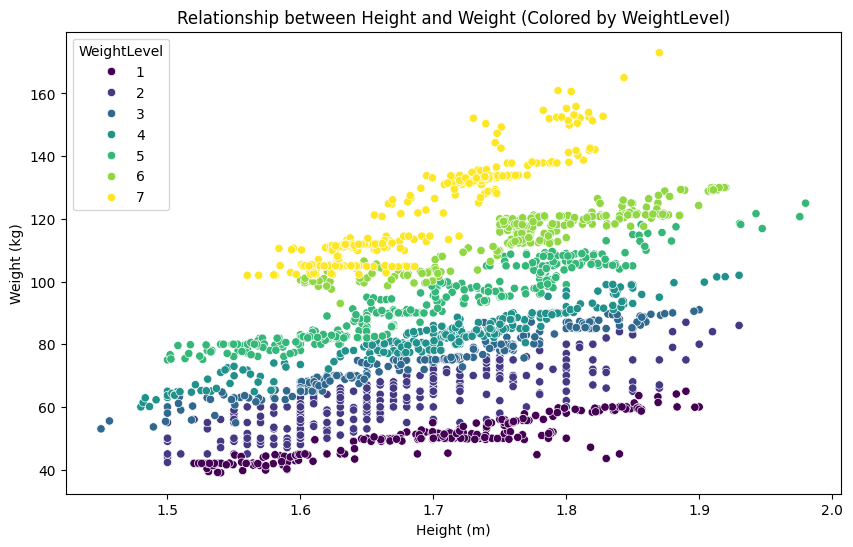

In [40]:
# Scatter plot to explore the relationship between 'Height' and 'Weight', colored by 'WeightLevel'
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='Height', y='Weight', hue='WeightLevel', palette='viridis')
plt.title('Relationship between Height and Weight (Colored by WeightLevel)')
plt.xlabel('Height (m)')
plt.ylabel('Weight (kg)')
plt.legend(title='WeightLevel', loc='upper left')
plt.show()

# 4. Overweight / Not Overweight model 

# 4.1 Model setup

In [59]:
# 1) Prepare train/test sets
y = data.Overweight
X = data.drop(columns=['Overweight', 'NObeyesdad'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=0,
    stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)


In [60]:
# 2) Define base models
models = {
    "RandomForest": RandomForestClassifier(random_state=0),
    "AdaBoost":    AdaBoostClassifier(random_state=0),
    "GBM":         GradientBoostingClassifier(random_state=0),
    "HistGBM":     HistGradientBoostingClassifier(random_state=0),
    "XGBoost":     XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=0),
}


In [61]:
# 3) Define hyperparameter grids
param_grids = {
    "RandomForest": {
        "n_estimators": [100, 200, 500],
        "max_depth":    [None, 5, 10],
        "min_samples_split": [2, 5, 10]
    },
    "AdaBoost": {
        "n_estimators": [50, 100, 200],
        "learning_rate":[0.5, 1.0, 1.5]
    },
    "GBM": {
        "n_estimators":   [100, 200, 500],
        "learning_rate":  [0.01, 0.05, 0.1],
        "max_depth":      [3, 5, 7]
    },
    "HistGBM": {
        "max_iter":       [100, 200],
        "learning_rate":  [0.01, 0.05, 0.1],
        "max_depth":      [None, 5, 10]
    },
    "XGBoost": {
         "n_estimators": [100, 200, 500],
         "learning_rate": [0.01, 0.05, 0.1],
         "max_depth":     [3, 5, 7]
     }
}


# 4.2 Hyperparameter tuning


In [62]:
# 4) Hyperparameter tuning
tuned_models = {}
for name, base_clf in models.items():
    print(f"Tuning {name}...")
    grid = GridSearchCV(
        estimator=base_clf,
        param_grid=param_grids[name],
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train, y_train)
    print(f" → Best params for {name}: {grid.best_params_}")
    print(f" → Best CV acc:         {grid.best_score_:.4f}\n")
    tuned_models[name] = grid.best_estimator_

Tuning RandomForest...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
 → Best params for RandomForest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
 → Best CV acc:         0.9760

Tuning AdaBoost...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/cm/shared/apps/ufrc-python/current/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/cm/shared/apps/ufrc-python/current/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/cm/shared/apps/ufrc-python/current/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/cm/shared/apps/ufrc-python/current/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed i

 → Best params for AdaBoost: {'learning_rate': 0.5, 'n_estimators': 200}
 → Best CV acc:         0.9886

Tuning GBM...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
 → Best params for GBM: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
 → Best CV acc:         0.9880

Tuning HistGBM...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
 → Best params for HistGBM: {'learning_rate': 0.05, 'max_depth': 5, 'max_iter': 200}
 → Best CV acc:         0.9918

Tuning XGBoost...
Fitting 5 folds for each of 27 candidates, totalling 135 fits


/home/moralesmurallesm/.local/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:01:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/moralesmurallesm/.local/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:01:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/moralesmurallesm/.local/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:01:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/moralesmurallesm/.local/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:01:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/moralesmurallesm/.

 → Best params for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
 → Best CV acc:         0.9918



In [19]:
# 5) Build a soft-voting ensemble from your top 4 tuned models (including XGBoost)
tuned_models["Voting"] = VotingClassifier(
    estimators=[
        ('rf',   tuned_models["RandomForest"]),
        ('gbm',  tuned_models["GBM"]),
        ('ada',  tuned_models["AdaBoost"]),
        ('xgb',  tuned_models["XGBoost"])
    ],
    voting='soft'
)

In [20]:
# 6) Cross-validate all tuned models
cv_summary = []
for name, clf in tuned_models.items():
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    cv_summary.append({
        'model': name,
        'mean_cv_acc': np.mean(scores),
        'std_cv_acc':  np.std(scores)
    })

cv_df = pd.DataFrame(cv_summary).sort_values('mean_cv_acc', ascending=False)
print("CV results for tuned models:\n", cv_df)

/cm/shared/apps/ufrc-python/current/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/cm/shared/apps/ufrc-python/current/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/cm/shared/apps/ufrc-python/current/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/cm/shared/apps/ufrc-python/current/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed i

CV results for tuned models:
           model  mean_cv_acc  std_cv_acc
3       HistGBM     0.991784    0.005513
4       XGBoost     0.991782    0.004736
5        Voting     0.988622    0.005525
1      AdaBoost     0.988622    0.007101
2           GBM     0.987987    0.007861
0  RandomForest     0.975989    0.007106


/home/moralesmurallesm/.local/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:26:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


# 4.3 Results


### Test the model after hyperparameter tuning

In [25]:
# 7) Final evaluation: train best model on full training set & test
best_name = cv_df.iloc[0]['model']
best_clf  = tuned_models[best_name]
print(f"\nTraining best model ({best_name}) on full training set...")
best_clf.fit(X_train, y_train)

y_pred = best_clf.predict(X_test)


Training best model (HistGBM) on full training set...


In [26]:
print(f'Model score on training data: {best_clf.score(X_train, y_train)}')
print(f'Model score on testing data: {best_clf.score(X_test, y_test)}')

Model score on training data: 1.0
Model score on testing data: 0.9791666666666666


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       140
           1       0.98      0.99      0.99       388

    accuracy                           0.98       528
   macro avg       0.97      0.97      0.97       528
weighted avg       0.98      0.98      0.98       528



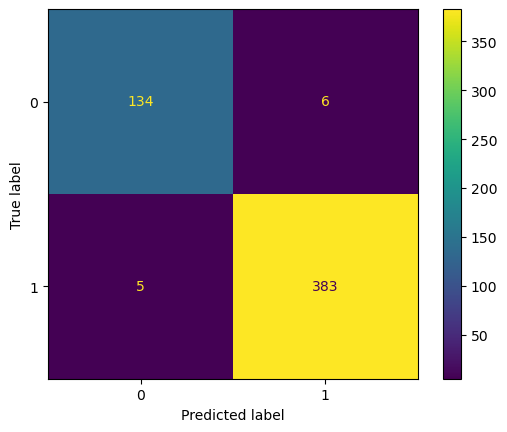

In [27]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_clf.classes_).plot()
plt.show()

### Use the model to make a prediction of overweight / not overweight.

In [51]:
# Create a dataset with data that matches the model's expected features
data_subject = pd.DataFrame({
    'Gender': [0],  # 1 for Male, 0 for Female
    'Age': [37],  # Age in years
    'Height': [1.73],  # Height in meters
    'Weight': [48.3],  # Weight in kilograms
    'family_history_with_overweight': [1],  # 1 for yes, 0 for no
    'FAVC': [1],  # Eat high caloric food: 1 for yes, 0 for no
    'FCVC': [1],  # Frequency for vegetables consumption: Never = 1, Sometimes = 2, Always = 3    
    'NCP': [3],  # Daily number of meals: Between 1-2 = 1, Three = 2, More than three = 3
    'CAEC': [1],  # Frequency for eating between meals: No = 0, Sometimes = 1, Frequently = 2, Always = 3
    'SMOKE': [1],  # 1 for yes, 0 for no
    'CH2O': [2],  # Water consumption: < 1 Liter = 1, 1-2 Liters = 2, > 2 Liters = 3
    'SCC': [0],  # Monitor calories: 1 for yes, 0 for no
    'FAF': [0],  # Frequency for physical activity: Do not do any = 0, 1-2 times/week = 1, 3-4 times/week = 2, > 4 times/week = 3
    'TUE': [2],  # Time spent on technological devices: < 2 hours = 0, 2-5 hours = 1, > 5 hours = 2
    'CALC': [0],  # Frequency for alcohol consumption: Do not drink = 0, Sometimes = 1, Frequently = 2, Always = 3
    'MTRANS': [1]  # Transportation mode: Public_Transportation = 1, Walking = 2, Automobile = 3, Motorbike = 4, Bike = 5
})

# Ensure the data is scaled using the same scaler as the training data
data_subject_scaled = scaler.transform(data_subject)

# Predict using the trained model
prediction = best_clf.predict(data_subject_scaled)

# Map the prediction to the corresponding weight level
overweight = {
    0: 'Not overweight',
    1: 'Overweight'
}

# Display the prediction
predicted_overweight = overweight.get(prediction[0], "Unknown Level")
print(f"Prediction for subject: {predicted_overweight}")


Prediction for subject: Not overweight


# 5. Weight level model

# 5.1 Model setup

##### The initial approach was to use logistic regression, but the results remained unsatisfactory even after hyperparameter tuning. 
##### As a next step, the LinearDiscriminantAnalysis function from scikit-learn was explored. This function implements Fisher’s Linear Discriminant, a supervised machine learning method that reduces dimensionality while maximizing class separability.

In [43]:
# 1) Setup train/test data

# Get the y values and drop from df
y = data.WeightLevel
X = data.drop(columns=['WeightLevel', 'Overweight', 'NObeyesdad'])

# Split to 75% train, 25% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Scale the data in x_train and x_test
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# 2) Define the base model

lda = LinearDiscriminantAnalysis()

# 5.2 Hyperparameter tuning


##### In Linear Discriminant Analysis the 'svd', 'lsqr', and 'eigen' have different advantages: 
- 'svd' is fast and ideal for dimensionality reduction but doesn't support shrinkage (regularization). 
- 'lsqr' is suitable for large datasets and supports shrinkage, but it's only used for classification. 
- 'eigen' supports both shrinkage and dimensionality reduction, making it good for interpretability, though it's slower and more sensitive numerically.

In [ ]:
# 3) Define the hyperparameters to tune. 
# This grid is used to test different combinations of solvers and shrinkage values during hyperparameter tuning.
param_grid = [
    {'solver': ['svd']},  # 'svd' does not support shrinkage
    {'solver': ['lsqr', 'eigen'], 'shrinkage': [None, 'auto', 0.1, 0.5, 0.9]}  # Shrinkage is valid for 'lsqr' and 'eigen'
]

# Configure GridSearchCV
grid_search = GridSearchCV(estimator=lda, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)

# Fit the model with the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the best score
print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Best accuracy: {grid_search.best_score_}")

# Use the best model found
best_lda = grid_search.best_estimator_

Fitting 5 folds for each of 11 candidates, totalling 55 fits
Best hyperparameters: {'solver': 'svd'}
Best accuracy: 0.8894621251447511


# 5.3 Results


In [47]:
# 4) Get model.score for both training and test data for Fisher's Discriminant Analysis
print(f'Model score on training data: {best_lda.score(X_train, y_train)}')
print(f'Model score on testing data: {best_lda.score(X_test, y_test)}')

Model score on training data: 0.899557801642451
Model score on testing data: 0.8920454545454546


Classification Report:
              precision    recall  f1-score   support

           1       0.89      0.95      0.92        78
           2       0.81      0.67      0.73        69
           3       0.74      0.79      0.77        68
           4       0.79      0.86      0.83        66
           5       0.99      0.92      0.95        86
           6       0.97      1.00      0.99        73
           7       1.00      1.00      1.00        88

    accuracy                           0.89       528
   macro avg       0.88      0.88      0.88       528
weighted avg       0.89      0.89      0.89       528



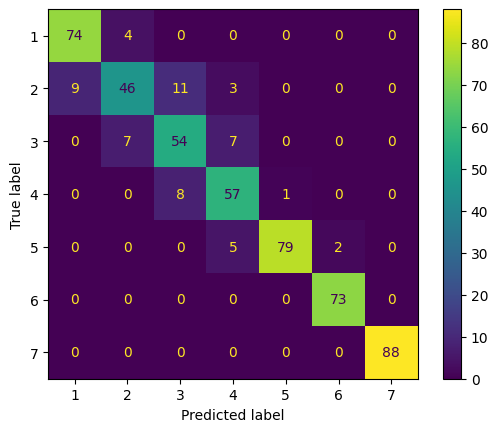

In [48]:
# 5) Make predictions
y_pred = best_lda.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_lda.classes_).plot()
plt.show()

# 5.4 Use Suport Vector Machines (SVM)

##### The third option was to use Support Vector Machines (SVM).  
##### We performed hyperparameter tuning using GridSearchCV, with predefined set of parameters and then find the best combination: 
- Regularization strength 'C'
- Kernel type ('linear', 'rbf', or 'poly')
- Kernel coefficient 'gamma'


In [49]:
# 1) Prepare the data
# Split the data into features (X) and target labels (y)
y = data['WeightLevel']  # Target variable
X = data.drop(columns=['WeightLevel', 'Overweight', 'NObeyesdad'])  # Features

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)

# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 2) Define the SVM model
svm = SVC(probability=True, random_state=0)

# 3) Perform hyperparameter tuning with GridSearchCV
param_grid = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],  # Kernel types
    'gamma': ['scale', 'auto']  # Kernel coefficient
}

grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best accuracy: {grid_search.best_score_}")

# Use the best model found
best_svm = grid_search.best_estimator_

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Best accuracy: 0.9570418879527212


In [47]:
# 4) Get model.score for both training and test data for Support Vector Machines (SVM)
print(f'Model score on training data: {best_svm.score(X_train, y_train)}')
print(f'Model score on testing data: {best_svm.score(X_test, y_test)}')

Model score on training data: 0.9804169298799748
Model score on testing data: 0.9678030303030303


Classification Report:
              precision    recall  f1-score   support

           1       0.97      1.00      0.99        68
           2       1.00      0.96      0.98        72
           3       0.92      0.95      0.93        73
           4       0.91      0.93      0.92        72
           5       1.00      0.97      0.98        88
           6       0.97      1.00      0.99        74
           7       1.00      0.98      0.99        81

    accuracy                           0.97       528
   macro avg       0.97      0.97      0.97       528
weighted avg       0.97      0.97      0.97       528



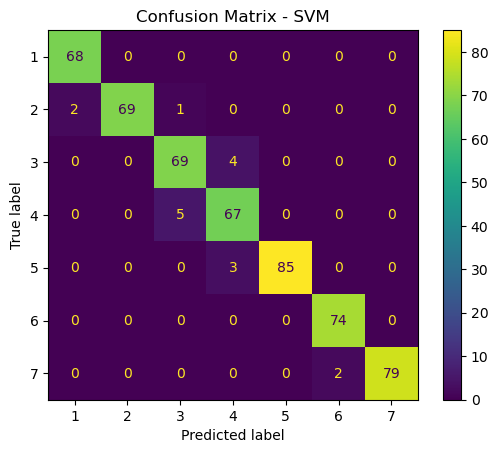

In [48]:
# 5) Evaluate the model on the test set
y_pred = best_svm.predict(X_test)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_svm.classes_).plot(cmap='viridis')
plt.title("Confusion Matrix - SVM")
plt.show()

### Use the SVM model to make a prediction of weight level.

In [52]:
# Create a dataset with data that matches the model's expected features
data_subject = pd.DataFrame({
    'Gender': [0],  # 1 for Male, 0 for Female
    'Age': [37],  # Age in years
    'Height': [1.73],  # Height in meters
    'Weight': [48.3],  # Weight in kilograms
    'family_history_with_overweight': [1],  # 1 for yes, 0 for no
    'FAVC': [1],  # Eat high caloric food: 1 for yes, 0 for no
    'FCVC': [1],  # Frequency for vegetables consumption: Never = 1, Sometimes = 2, Always = 3    
    'NCP': [3],  # Daily number of meals: Between 1-2 = 1, Three = 2, More than three = 3
    'CAEC': [1],  # Frequency for eating between meals: No = 0, Sometimes = 1, Frequently = 2, Always = 3
    'SMOKE': [1],  # 1 for yes, 0 for no
    'CH2O': [2],  # Water consumption: < 1 Liter = 1, 1-2 Liters = 2, > 2 Liters = 3
    'SCC': [0],  # Monitor calories: 1 for yes, 0 for no
    'FAF': [0],  # Frequency for physical activity: Do not do any = 0, 1-2 times/week = 1, 3-4 times/week = 2, > 4 times/week = 3
    'TUE': [2],  # Time spent on technological devices: < 2 hours = 0, 2-5 hours = 1, > 5 hours = 2
    'CALC': [0],  # Frequency for alcohol consumption: Do not drink = 0, Sometimes = 1, Frequently = 2, Always = 3
    'MTRANS': [1]  # Transportation mode: Public_Transportation = 1, Walking = 2, Automobile = 3, Motorbike = 4, Bike = 5
})

# Ensure the data is scaled using the same scaler as the training data
data_subject = scaler.transform(data_subject)

# Predict using the trained model
prediction = best_svm.predict(data_subject)

# Map the prediction to the corresponding weight level
weight_levels = {
    1: 'Insufficient Weight',
    2: 'Normal Weight',
    3: 'Overweight Level I',
    4: 'Overweight Level II',
    5: 'Obesity Type I',
    6: 'Obesity Type II',
    7: 'Obesity Type III'
}

# Display the prediction
predicted_level = weight_levels.get(prediction[0], "Unknown Level")
print(f"Prediction for subject: {predicted_level}")

Prediction for subject: Insufficient Weight


# 6. Discussion


### 6.1 Summary of Model Performance: Predicting Overweight / Not Overweight

### 6.2 Summary of Model Performance: Predicting WeightLevel

1. Linear Discriminant Analysis (LDA)

- LDA is computationally efficient and performed well on the dataset, resulting in good precision, record, f-1 score. 
- Training accuracy was high, indicating the model fit the training data well, however test accuracy was lightly lower than training accuracy, showing some generalization issues.
- Hyperparameter tuning (e.g., solver and shrinkage) improved the model's performance, with the best parameters selected using GridSearchCV.
- LDA assumes that the data follows a Gaussian distribution, which may not be true for all features in the dataset.
- The model resulted in some missclassifications,particularly in levels 2 and 3 of weight. 
- Performance on the test set was slightly lower than on the training set, indicating potential overfitting.

2. Support Vector Machines (SVM)

- SVM performed well with non-linear relationships in the data. 
- Training accuracy was high, indicating the model fit the training data well, and test accuracy was slightly better than LDA. 
- Hyperparameter tuning (e.g., C, kernel, and gamma) significantly improved the model's performance, with the best parameters selected using GridSearchCV.
- The model showed better results compared to LDA.
- SVM can be very slow and require a lot of computer power, especially with large datasets.
- While SVM performed better overall, it still had some misclassifications for closely related weight levels.